In [173]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot
import numpy as np

## Loading in the mortality data
#### TODO Is grouping them by country and getting the mean the way to go? Do we simply take the latest 5 years? need more looking into

In [174]:
data=pd.read_csv("Data/adult_mortality_by_country.csv",header=1)
mortality=data.drop(columns=['Male','Female'])
mortality=mortality.rename(columns={"Both sexes": "mortality_rate"})
mortality['mortality_rate'].describe()
mortality['Year']=pd.to_datetime(mortality['Year'],format='%Y')
mortality=mortality.groupby(['Country']).mean()
mortality.describe()

,mortality_rate
count,183.000000
mean,193.530376
std,109.179405
min,59.117647
25%,110.264706
50%,164.882353
75%,252.294118
max,549.352941


##  Visualizing outliers

#### The outliers in the outliers are not real outliers rather variance, apparently some countries really have that high of a mortality rate

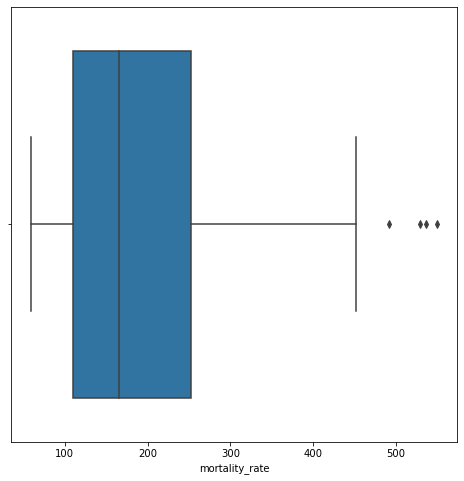

In [175]:
fig, ax= pyplot.subplots(figsize=(8,8))
sns.boxplot(x="mortality_rate", data=mortality, ax=ax)

In [176]:
mortality.loc[mortality["mortality_rate"]>300]

,mortality_rate
Country,
Botswana,431.294118
Burundi,334.941176
Cameroon,375.176471
Central African Republic,491.647059
Chad,391.470588
Congo,341.470588
Côte d'Ivoire,437.117647
Equatorial Guinea,341.588235
Eritrea,322.000000


## Defining Low and High mortality rate
#### TODO- SHOULD DOUBLE CHECK WHAT IS HIGH AND LOW MORTALITY. FOR NOW CHOSE ACCORDING TO THE QUARTILES

In [177]:
mortality['mortality_rate'] = np.where(mortality['mortality_rate'] <150, 'low', 'high')
mortality.head(15)                                                             

,mortality_rate
Country,
Afghanistan,high
Albania,low
Algeria,low
Angola,high
Antigua and Barbuda,low
Argentina,low
Armenia,low
Australia,low
Austria,low


#### View number of countries with low and high mortality rate

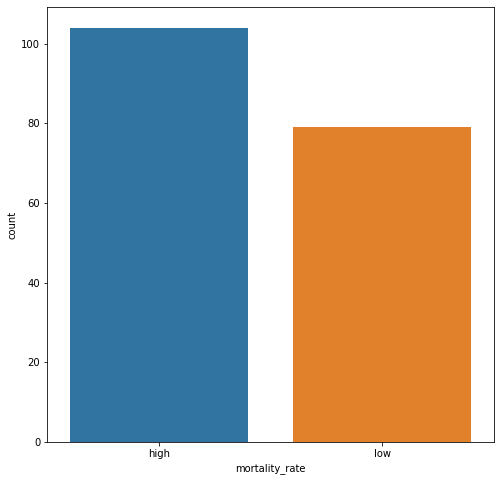

In [178]:
fig, ax= pyplot.subplots(figsize=(8,8))
sns.countplot(x=mortality['mortality_rate'],ax=ax)

## Loading in the mortality data
#### TODO Is grouping them by country and getting the mean the way to go? Do we simply take the latest 5 years? need more looking into

In [179]:
data=pd.read_csv("Data/medical_doctors.csv")
doctors=data.drop(data.columns[[3,4,5,6]], axis=1)
doctors['Year']=pd.to_datetime(doctors['Year'],format='%Y')
doctors=doctors.rename(columns={"Medical doctors (per 10 000 population)": "medical_doctors"})
doctors=doctors.groupby(['Country']).mean()

#### By merging as below, we take the union of both dataframes therefore we're eliminating some rows which don't exist in the other

In [180]:
merged_data = pd.merge(left=mortality, right=doctors, left_on='Country', right_on='Country')
merged_data.head(5)

,mortality_rate,medical_doctors
Country,,
Afghanistan,high,2.322167
Albania,low,13.092864
Algeria,low,14.450000
Angola,high,1.168000
Antigua and Barbuda,low,13.394500


## Viewing correlation of data

In [181]:
df=pd.get_dummies(merged_data['mortality_rate'])
df_corr = pd.concat([merged_data, df], axis=1)
df_corr.head(2)

,mortality_rate,medical_doctors,high,low
Country,,,,
Afghanistan,high,2.322167,1,0
Albania,low,13.092864,0,1


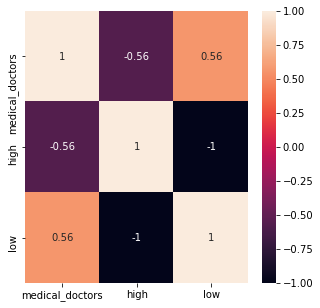

In [182]:
fig, ax= pyplot.subplots(figsize=(5,5))
sns.heatmap(df_corr.corr(),annot=True)